# Vector-Quantized Variational Autoencoders

**Author:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Date created:** 2021/07/21<br>
**Last modified:** 2022/06/27<br>
**Description:** Training a VQ-VAE for image reconstruction and codebook sampling for generation.

## Imports

In [390]:
!pip install -q tensorflow-probability
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf
import cv2


**A note on straight-through estimation**:

This line of code does the straight-through estimation part: `quantized = x +
tf.stop_gradient(quantized - x)`. During backpropagation, `(quantized - x)` won't be
included in the computation graph and the gradients obtained for `quantized`
will be copied for `inputs`. Thanks to [this video](https://youtu.be/VZFVUrYcig0?t=1393)
for helping me understand this technique.

## Residual 

In [ ]:
class ResidualVectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, num_quantizers, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.num_quantizers = num_quantizers  # Number of residual quantization stages
        self.beta = beta

        # Create multiple embedding matrices (one per quantization stage)
        w_init =  tf.keras.initializers.RandomUniform()
        self.embeddings = [
            tf.Variable(
                initial_value=w_init(
                    shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
                ),
                trainable=True,
                name=f"embeddings_vqvae_{i}",
            )
            for i in range(self.num_quantizers)
        ]

    def call(self, x):
        shape = tf.shape(x)  # Get dynamic shape
        batch_size, height, width, channels = shape[0], shape[1], shape[2], shape[3]
        flattened = tf.reshape(x, [batch_size * height * width, channels])

        residual = flattened
        quantized_output = tf.zeros_like(flattened)
        total_commitment_loss = 0
        total_codebook_loss = 0


        for i in range(self.num_quantizers):
         
            encoding_indices = self.get_code_indices(residual, self.embeddings[i])
            encodings = tf.one_hot(encoding_indices, self.num_embeddings)
            quantized = tf.matmul(encodings, self.embeddings[i], transpose_b=True)

            
            # Compute loss
            codebook_loss = tf.reduce_mean((tf.stop_gradient(residual) - quantized) ** 2)
            commitment_loss = tf.reduce_mean((residual - tf.stop_gradient(quantized)) ** 2)
            total_commitment_loss += commitment_loss
            total_codebook_loss += codebook_loss

            residual -= quantized
            quantized_output += quantized
    

        total_loss = self.beta * total_commitment_loss + total_codebook_loss
        self.add_loss(total_loss)

        # Reshape back to (batch, height, width, channels)
        quantized_output = tf.reshape(quantized_output, [batch_size, height, width, channels])

        # Straight-through estimator
        quantized_output = x + tf.stop_gradient(quantized_output - x)
        return quantized_output

    def get_code_indices(self, inputs, embedding_matrix):
        # Calculate L2-normalized distance between inputs and codebook vectors
        similarity = tf.matmul(inputs, embedding_matrix)
        distances = (
            tf.reduce_sum(inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(embedding_matrix ** 2, axis=0)
            - 2 * similarity
        )

        # Get the index of the nearest codebook vector
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices


## Encoder and decoder

Now for the encoder and the decoder for the VQ-VAE. We will keep them small so
that their capacity is a good fit for the MNIST dataset. The implementation of the encoder and
come from
[this example](https://keras.io/examples/generative/vae).

Note that activations _other than ReLU_ may not work for the encoder and decoder layers in the
quantization architecture: Leaky ReLU activated layers, for example, have proven difficult to
train, resulting in intermittent loss spikes that the model has trouble recovering from.

In [ ]:

def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")


## Defining RQ

In [4]:

def get_vqvae(latent_dim=4, num_embeddings=64,num_quantizers =2):
    rvq_layer = ResidualVectorQuantizer(num_embeddings, latent_dim,num_quantizers, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(28, 28, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = rvq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="rvq_vae")

get_vqvae().summary()

Model: "rvq_vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 7, 7, 4)        │        19,076 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vector_quantizer                │ (None, 7, 7, 4)        │             0 │
│ (ResidualVectorQuantizer)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │        21,121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,197 (157.02 KB)

 Trainable params: 40,197 (157.02 KB)

 Non-trainable params: 0 (0.00 B)

## Wrapping up the training loop inside `RVQVAETrainer`

In [5]:

class RVQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, num_quantizers = 2,**kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings
        self.num_quantizers = num_quantizers

        self.rvqvae = get_vqvae(self.latent_dim, self.num_embeddings, self.num_quantizers)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.rvq_loss_tracker = keras.metrics.Mean(name="rvq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.rvq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.rvqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.rvqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.rvqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.rvqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.rvq_loss_tracker.update_state(sum(self.rvqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "rvqvae_loss": self.rvq_loss_tracker.result(),
        }


## Load and preprocess the MNIST dataset

In [6]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

data_variance = np.var(x_train / 255.0)

## Train the VQ-VAE model

In [387]:
num_quant = 1
vqvae_trainer = RVQVAETrainer(data_variance, latent_dim=16, num_embeddings=512, num_quantizers = num_quant)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
history = vqvae_trainer.fit(x_train_scaled, epochs=50, batch_size=128)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - loss: 63.3384 - reconstruction_loss: 0.6546 - rvqvae_loss: 62.6838
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 263.3599 - reconstruction_loss: 0.1090 - rvqvae_loss: 263.2510
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 56ms/step - loss: 234.0476 - reconstruction_loss: 0.0864 - rvqvae_loss: 233.9612
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 31s 65ms/step - loss: 238.2285 - reconstruction_loss: 0.0800 - rvqvae_loss: 238.1484
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 31s 65ms/step - loss: 248.0072 - reconstruction_loss: 0.0740 - rvqvae_loss: 247.9333
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 70ms/step - loss: 250.5705 - reconstruction_loss: 0.0704 - rvqvae_loss: 250.5000
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 70ms/step - loss: 241.0984 - reconstruction_loss: 0.0678 - rvqvae_loss: 241.0306
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - loss: 252.0079 - reconstruction_loss: 0.0669 - rvqvae_loss: 251.9411
Ep

## Reconstruction results on the test set

In [388]:

def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()

samples = 3
trained_vqvae_model = vqvae_trainer.rvqvae
idx = np.random.choice(len(x_test_scaled), 10000)
test_images = x_test_scaled[idx]
test_images_sub = test_images[:1000]
reconstructions_test = trained_vqvae_model.predict(test_images_sub)

#for test_image, reconstructed_image in zip(test_images_sub, reconstructions_test):
 #   show_subplot(test_image, reconstructed_image)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


## Visualizing the discrete codes

Loading image

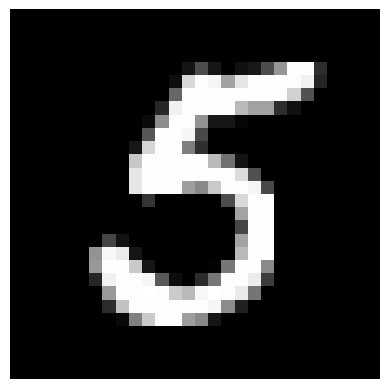

(1, 28, 28, 1)

In [273]:

# Load the image in grayscale (0 means grayscale)
image = cv2.imread(r'E:\Second Term\Gen AI\Project\mnist_random_image.png', cv2.IMREAD_GRAYSCALE)
image = image/255 -0.5
expanded_image = np.expand_dims(image, axis=0)  # Shape becomes (1, 28, 28)
expanded_image = np.expand_dims(expanded_image, axis=-1)  # Shape becomes (1, 28, 28, 1)

# Display the image using matplotlib
plt.imshow(image, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()
np.shape(expanded_image)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Error at quantization stage 1 (L2 norm): 2.193547248840332
Error at quantization stage 2 (L2 norm): 2.135688543319702
Error at quantization stage 3 (L2 norm): 2.0877902507781982
Error at quantization stage 4 (L2 norm): 2.061457633972168


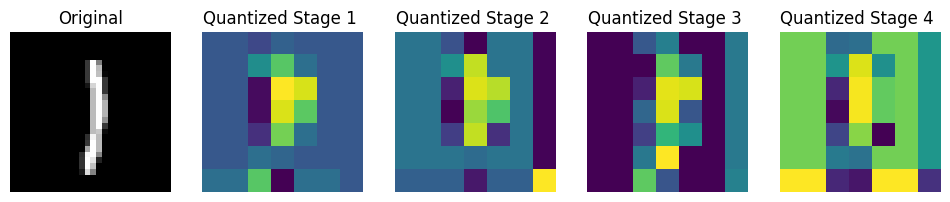

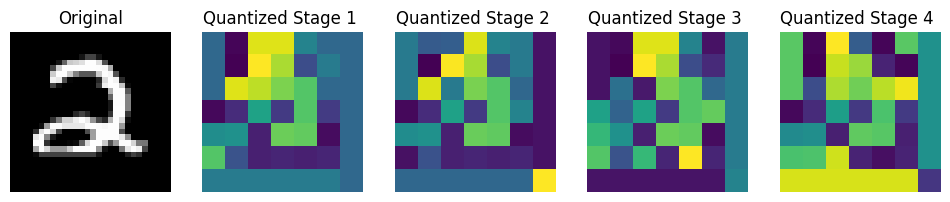

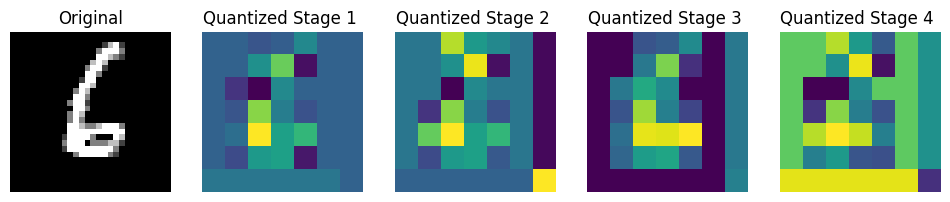

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Get the encoder and vector quantizer layers
encoder = vqvae_trainer.rvqvae.get_layer("encoder")
quantizer = vqvae_trainer.rvqvae.get_layer("vector_quantizer")


num_random_images = 1
random_indices = np.random.choice(test_images.shape[0], num_random_images, replace=False)

#test_images_subset = test_images[random_indices]
test_images_subset = test_images[:3]

encoded_outputs = encoder.predict(test_images_subset)  
batch_size, height, width, channels = encoded_outputs.shape
flat_enc_outputs = encoded_outputs.reshape(batch_size * height * width, channels)

all_quantized_outputs = []

residual = flat_enc_outputs
for i in range(quantizer.num_quantizers):
    embedding_matrix = quantizer.embeddings[i] 
    
    codebook_indices = quantizer.get_code_indices(residual, embedding_matrix)
    
    encodings = tf.one_hot(codebook_indices, quantizer.num_embeddings)
    quantized = tf.matmul(encodings, embedding_matrix, transpose_b=True)
    
    all_quantized_outputs.append(quantized.numpy().reshape(batch_size, height, width, channels))

    residual -= quantized
    
    error = tf.norm(residual, axis=-1)  
    error_value = tf.reduce_mean(error).numpy()  
    print(f"Error at quantization stage {i + 1} (L2 norm): {error_value}")


# Visualize individual channels from the quantized output
for i in range(len(test_images_subset)):
    plt.figure(figsize=(12, 6))

    # Plot the original image
    plt.subplot(1, len(all_quantized_outputs) + 1, 1)
    plt.imshow(test_images_subset[i].squeeze() + 0.5, cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Plot individual channels from the quantized output after each quantization stage
    for j, quantized_output in enumerate(all_quantized_outputs):
        plt.subplot(1, len(all_quantized_outputs) + 1, j + 2)
        plt.imshow(quantized_output[i, :, :, 0], cmap="viridis")  # Show the first channel
        plt.title(f"Quantized Stage {j + 1} ")
        plt.axis("off")

    plt.show()


In [ ]:
import tensorflow as tf
import numpy as np

def get_quantized_token_indices(test_images, encoder, quantizer):

  
    encoded_outputs = encoder.predict(test_images)  
    batch_size, height, width, channels = encoded_outputs.shape

    # Flatten spatial dims
    flat_enc_outputs = encoded_outputs.reshape(batch_size * height * width, channels)

    # Collect codebook indices at each stage
    all_indices = []

    residual = flat_enc_outputs
    for i in range(quantizer.num_quantizers):
        embedding_matrix = quantizer.embeddings[i]
        codebook_indices = quantizer.get_code_indices(residual, embedding_matrix)
        all_indices.append(codebook_indices.numpy().reshape(batch_size, height * width))
        
        # Quantized vectors
        encodings = tf.one_hot(codebook_indices, quantizer.num_embeddings)
        quantized = tf.matmul(encodings, embedding_matrix, transpose_b=True)
        
        # Residual for next stage
        residual -= quantized

    quantized_tokens = np.stack(all_indices, axis=-1)  
    return quantized_tokens


In [ ]:
encoder = vqvae_trainer.rvqvae.get_layer("encoder")
quantizer = vqvae_trainer.rvqvae.get_layer("vector_quantizer")

quantized_tokens = get_quantized_token_indices(test_images, encoder, quantizer)

print(quantized_tokens.shape)  

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
(10000, 49, 1)


In [ ]:
from rq_transformer import RQTransformer  

rq_transformer = RQTransformer(
    num_tokens = quantizer.num_embeddings,  #Number of embdeddings in each quantizer
    dim = 512,                              
    max_spatial_seq_len = 49,              # matches 7x7 = 49 patches
    depth_seq_len = 2,                     # number of quantizers
    spatial_layers = 6,                    # number of transformer layers for spatial modeling
    depth_layers = 4,                      # number of transformer layers for depth modeling
    dim_head = 64,
    heads = 8
)



In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

tokens = torch.tensor(quantized_tokens[:1000], dtype=torch.long)
dataset = TensorDataset(tokens)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

optimizer = torch.optim.Adam(rq_transformer.parameters(), lr=1e-4)


for epoch in range(100):
    total_loss = 0
    for (x,) in loader:
        optimizer.zero_grad()
        loss = rq_transformer(x, return_loss=True)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1} - Loss: {total_loss:.4f}")


Epoch 1 - Loss: 0.7422
Epoch 2 - Loss: 0.7089
Epoch 3 - Loss: 0.7085
Epoch 4 - Loss: 0.6432
Epoch 5 - Loss: 0.6178
Epoch 6 - Loss: 0.6644
Epoch 7 - Loss: 0.6102
Epoch 8 - Loss: 0.5818
Epoch 9 - Loss: 0.5659
Epoch 10 - Loss: 0.6051
Epoch 11 - Loss: 0.6703
Epoch 12 - Loss: 0.6566
Epoch 13 - Loss: 0.6230
Epoch 14 - Loss: 0.6129
Epoch 15 - Loss: 0.5910
Epoch 16 - Loss: 0.5555
Epoch 17 - Loss: 0.5559
Epoch 18 - Loss: 0.5243
Epoch 19 - Loss: 0.5507
Epoch 20 - Loss: 0.5421
Epoch 21 - Loss: 0.5415
Epoch 22 - Loss: 0.5336
Epoch 23 - Loss: 0.6223
Epoch 24 - Loss: 0.7171
Epoch 25 - Loss: 0.7709
Epoch 26 - Loss: 0.6926
Epoch 27 - Loss: 0.7149
Epoch 28 - Loss: 0.6216
Epoch 29 - Loss: 0.6064
Epoch 30 - Loss: 0.5986
Epoch 31 - Loss: 0.5603
Epoch 32 - Loss: 0.5384
Epoch 33 - Loss: 0.5579
Epoch 34 - Loss: 0.5219
Epoch 35 - Loss: 0.5128
Epoch 36 - Loss: 0.5242
Epoch 37 - Loss: 0.5098
Epoch 38 - Loss: 0.5420
Epoch 39 - Loss: 0.5081
Epoch 40 - Loss: 0.5290
Epoch 41 - Loss: 0.5055
Epoch 42 - Loss: 0.5077
E

 ##  Generate tokens from RQ transformer

In [ ]:
batch_size = 100
samples = []

for i in range(batch_size):
    sample = rq_transformer.generate() 
    samples.append(sample.squeeze(0).cpu().numpy())  
    print(i)
generated_tokens = np.stack(samples, axis=0) 


In [ ]:
def transformer_tokens_to_latents_batch(generated_tokens, quantizer):
    """
    Converts RQTransformer-generated token indices (B, 49, 3) into quantized latent tensor (B, 7, 7, latent_dim)
    """
    batch_size, seq_len, num_quantizers = generated_tokens.shape
    h = w = int(seq_len ** 0.5)
    latent_dim = quantizer.embedding_dim

    quantized_latents = np.zeros((batch_size, seq_len, latent_dim), dtype=np.float32)

    for i in range(num_quantizers):
        codebook = quantizer.embeddings[i].numpy().T  
        indices = generated_tokens[:, :, i]  
        embeddings = codebook[indices]  
        quantized_latents += embeddings

    quantized_latents = quantized_latents.reshape(batch_size, h, w, latent_dim)
    return quantized_latents


## View images

In [ ]:

decoder_input = transformer_tokens_to_latents_batch(generated_tok, quantizer)  # (B, 7, 7, 4)
decoder_input_tensor = tf.convert_to_tensor(decoder_input, dtype=tf.float32)

# Step 2: Decode
decoder = vqvae_trainer.rvqvae.get_layer("decoder")
generated_images = decoder(decoder_input_tensor)  # (B, 28, 28, 1)

# Step 3: Visualize the batch
import matplotlib.pyplot as plt

for i in range(generated_images):
    plt.subplot(1, generated_images, i+1)
    plt.imshow(generated_images[i].numpy().squeeze(), cmap='gray')
    plt.axis('off')
plt.show()


In [327]:
import tensorflow as tf

real_images = tf.convert_to_tensor(x_test_scaled[:1000], dtype=tf.float32)
